In [1]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import random

class CremiDataset(Dataset):
    def __init__(self, hdf5_paths, patch_size=(64, 64, 64), mode='train', augment=False):
        """
        Args:
            hdf5_paths (list): List of paths to HDF5 files.
            patch_size (tuple): Size of 3D patches (depth, height, width).
            mode (str): 'train' or 'test'.
            augment (bool): Apply random augmentations.
        """
        self.hdf5_paths = hdf5_paths
        self.patch_size = patch_size
        self.mode = mode
        self.augment = augment
        self.data = []
        
        # Load data from all HDF5 files
        for path in hdf5_paths:
            with h5py.File(path, 'r') as f:
                raw = f['volumes/raw'][()]
                neuron_ids = f['volumes/labels/neuron_ids'][()]
                clefts = f['volumes/labels/clefts'][()]
                self.data.append((raw, neuron_ids, clefts))
    
    def __len__(self):
        return len(self.data) * 1000  # Large number for random sampling
    
    def random_crop(self, volume, label1, label2):
        """Extract a random patch of given size."""
        d, h, w = volume.shape
        pd, ph, pw = self.patch_size
        
        d0 = random.randint(0, d - pd)
        h0 = random.randint(0, h - ph)
        w0 = random.randint(0, w - pw)
        
        return (volume[d0:d0+pd, h0:h0+ph, w0:w0+pw],
                label1[d0:d0+pd, h0:h0+ph, w0:w0+pw],
                label2[d0:d0+pd, h0:h0+ph, w0:w0+pw])
    
    def augment_data(self, raw, label1, label2):
        """Apply random flipping and rotation for data augmentation."""
        if random.random() > 0.5:
            raw = np.flip(raw, axis=1).copy()
            label1 = np.flip(label1, axis=1).copy()
            label2 = np.flip(label2, axis=1).copy()
        if random.random() > 0.5:
            raw = np.flip(raw, axis=2).copy()
            label1 = np.flip(label1, axis=2).copy()
            label2 = np.flip(label2, axis=2).copy()
        return raw, label1, label2

    
    def __getitem__(self, idx):
        """Get a random patch from a random volume."""
        raw, neuron_ids, clefts = random.choice(self.data)
        raw_patch, neuron_patch, cleft_patch = self.random_crop(raw, neuron_ids, clefts)
        
        if self.augment:
            raw_patch, neuron_patch, cleft_patch = self.augment_data(raw_patch, neuron_patch, cleft_patch)
        
        # Convert to tensors
        raw_patch = torch.tensor(raw_patch, dtype=torch.float32).unsqueeze(0) / 255.0  # Normalize
        neuron_patch = torch.tensor(neuron_patch, dtype=torch.long)
        cleft_patch = torch.tensor(cleft_patch, dtype=torch.long)
        
        return raw_patch, neuron_patch, cleft_patch

# Example usage:
Base_dir = '/home/ri/Desktop/Projects/Datasets/CREMI/'
hdf5_paths = [Base_dir+'/'+'sample_A_20160501.hdf', Base_dir+'/'+'sample_B_20160501.hdf', Base_dir+'/'+'sample_C_20160501.hdf']
dataset = CremiDataset(hdf5_paths, patch_size=(3, 256, 256), mode='train', augment=True)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

# Get a batch
for raw, neuron, cleft in dataloader:
    print(raw.shape, neuron.shape, cleft.shape)
    break


torch.Size([8, 1, 3, 256, 256]) torch.Size([8, 3, 256, 256]) torch.Size([8, 3, 256, 256])


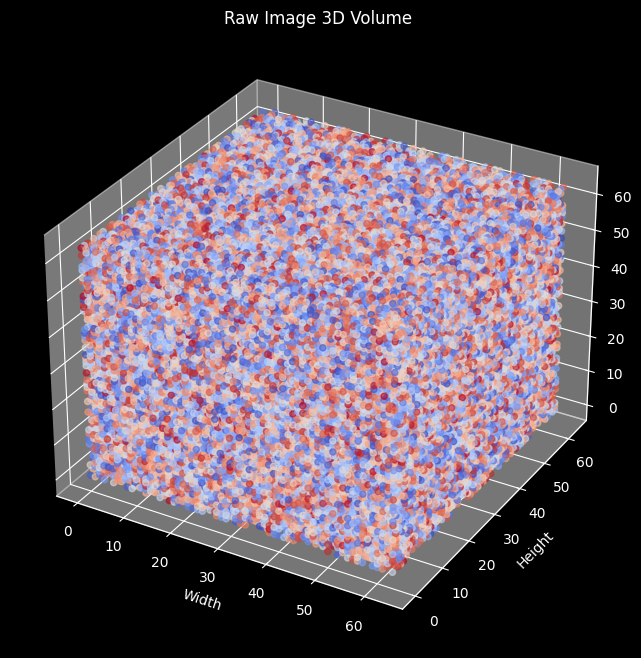

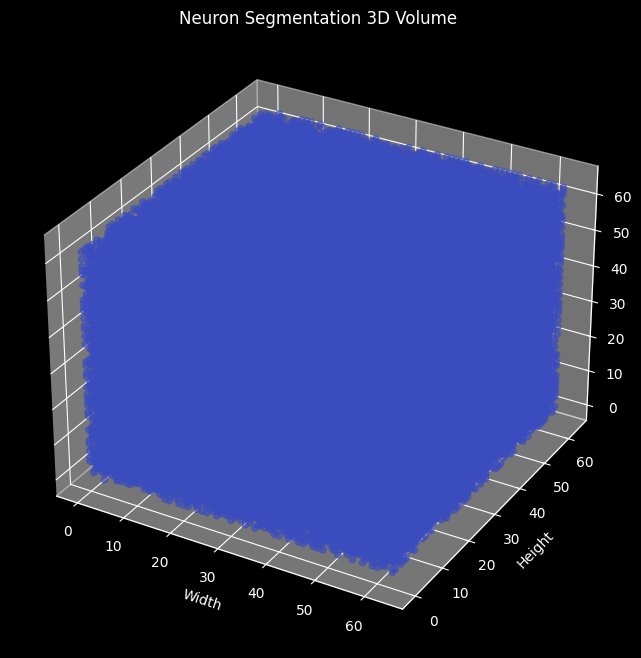

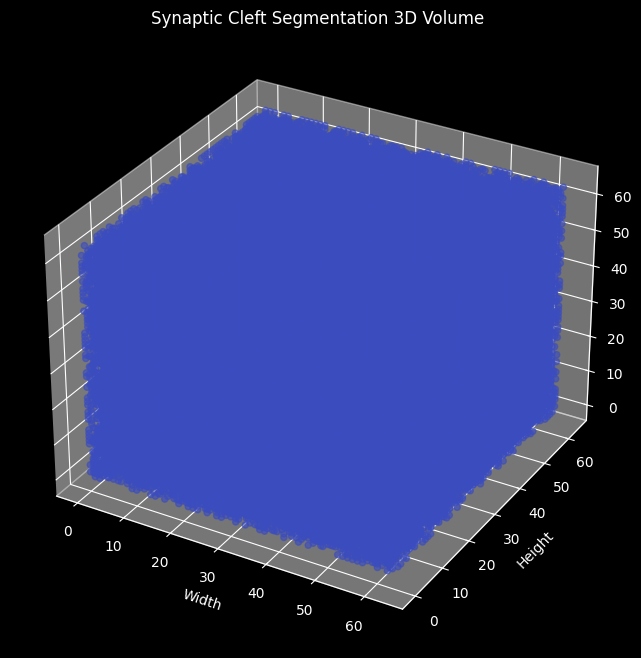

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to visualize a 3D tensor using scatter plot
def plot_3d_tensor(tensor, title="3D Volume", threshold=0.5):
    """Plots a 3D tensor using a scatter plot, showing only nonzero voxels."""
    tensor = tensor.squeeze().cpu().numpy()  # Convert to NumPy
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get coordinates where values exceed the threshold
    z, y, x = np.where(tensor > threshold)
    
    # Scatter plot of the 3D points
    ax.scatter(x, y, z, c=tensor[z, y, x], cmap="coolwarm", marker='o', alpha=0.6)
    
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_zlabel('Depth')
    ax.set_title(title)
    plt.show()

# Simulated batch from DataLoader
batch_size = 8
D, H, W = 64, 64, 64

# Create random tensors to simulate a batch
raw_batch = torch.rand((batch_size, 1, D, H, W))  # Grayscale raw images
neuron_batch = torch.randint(0, 2, (batch_size, D, H, W))  # Binary neuron segmentation
cleft_batch = torch.randint(0, 2, (batch_size, D, H, W))  # Binary synaptic cleft segmentation

# Plot 3D visualization for first sample in the batch
plot_3d_tensor(raw_batch[0], title="Raw Image 3D Volume")
plot_3d_tensor(neuron_batch[0], title="Neuron Segmentation 3D Volume")
plot_3d_tensor(cleft_batch[0], title="Synaptic Cleft Segmentation 3D Volume")


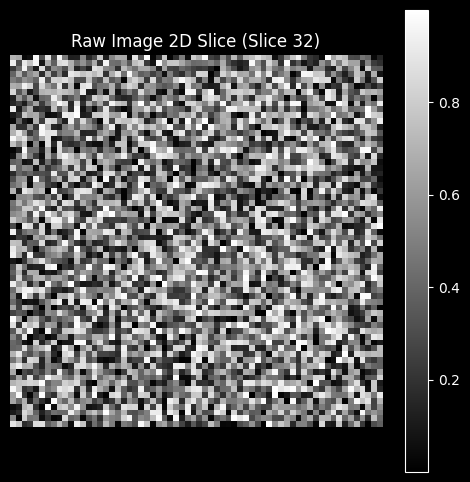

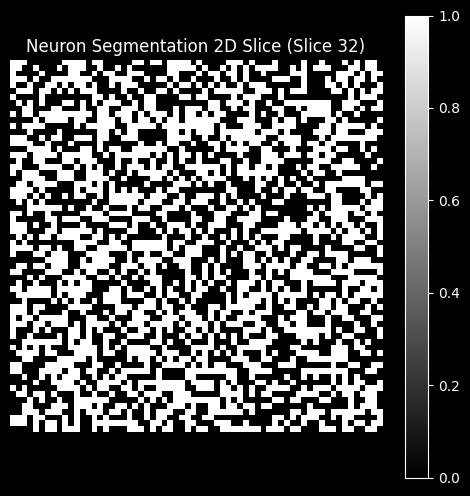

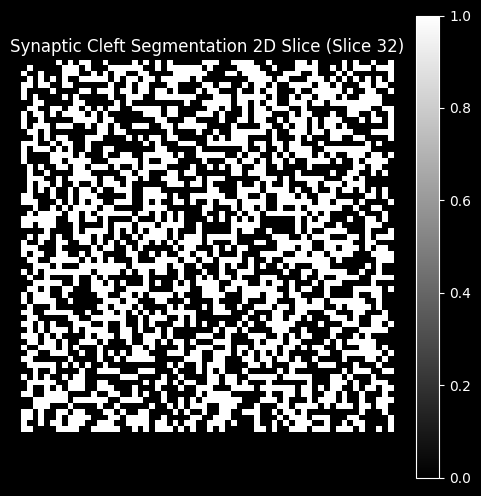

In [3]:
# Function to plot a 2D slice from the 3D volume
def plot_2d_slice(tensor, slice_idx=None, title="2D Slice"):
    """Plots a single 2D slice from a 3D tensor."""
    tensor = tensor.squeeze().cpu().numpy()  # Convert to NumPy
    
    # Select middle slice if not provided
    if slice_idx is None:
        slice_idx = tensor.shape[0] // 2  # Middle depth slice
    
    plt.figure(figsize=(6, 6))
    plt.imshow(tensor[slice_idx], cmap="gray")
    plt.colorbar()
    plt.title(f"{title} (Slice {slice_idx})")
    plt.axis("off")
    plt.show()

# Plot 2D slice from the first sample in the batch
plot_2d_slice(raw_batch[0], title="Raw Image 2D Slice")
plot_2d_slice(neuron_batch[0], title="Neuron Segmentation 2D Slice")
plot_2d_slice(cleft_batch[0], title="Synaptic Cleft Segmentation 2D Slice")


Raw volume shape: (125, 1250, 1250)


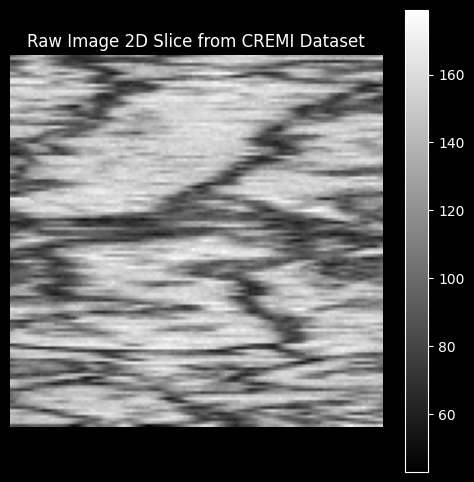

In [20]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load a sample file
hdf5_path = Base_dir+"/sample_A_20160501.hdf"  # Replace with an actual file path

with h5py.File(hdf5_path, "r") as f:
    raw_volume = f["volumes/raw"][()]  # Load raw image data
    
# Check shape
print("Raw volume shape:", raw_volume.shape)

# Plot a middle slice
plt.figure(figsize=(6, 6))
# plt.imshow(raw_volume[raw_volume.shape[0] // 2,:125,:125], cmap="gray")
# plt.imshow(raw_volume[:, :, raw_volume.shape[2] // 2], cmap="gray")
plt.imshow(raw_volume[:, raw_volume.shape[2] // 2+10, :125], cmap="gray")
plt.colorbar()
plt.title("Raw Image 2D Slice from CREMI Dataset")
plt.axis("off")
plt.show()


Original 3D Volume Shape: (125, 1250, 1250)
Cropped 3D Volume Shape: (96, 96, 96)


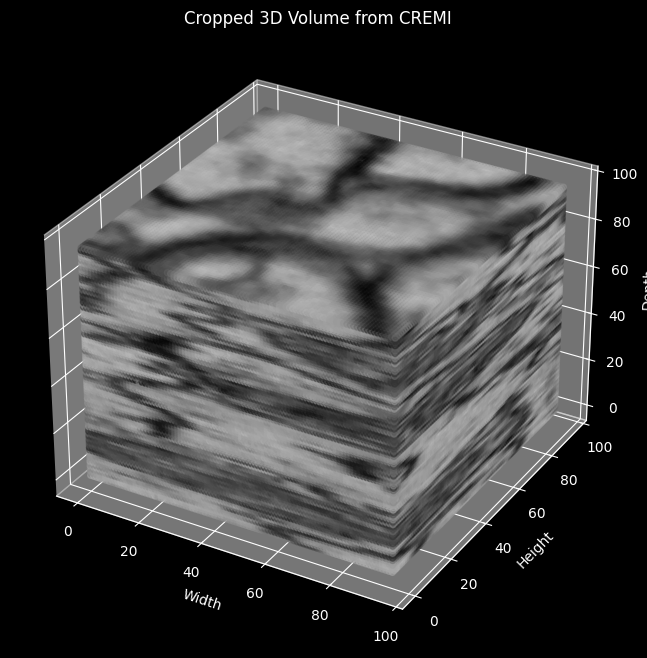

In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load a sample file
hdf5_path = Base_dir+"/sample_A_20160501.hdf"  # Replace with actual file path

with h5py.File(hdf5_path, "r") as f:
    raw_volume = f["volumes/raw"][()]  # Load raw image data

# Print original shape
print("Original 3D Volume Shape:", raw_volume.shape)

# Function to crop a 3D volume
def crop_3d(volume, crop_size=(32, 32, 32)):
    """Crops a 3D volume to a given size."""
    d, h, w = volume.shape
    cd, ch, cw = crop_size

    # Random crop start indices
    d0 = np.random.randint(0, d - cd)
    h0 = np.random.randint(0, h - ch)
    w0 = np.random.randint(0, w - cw)

    return volume[d0:d0 + cd, h0:h0 + ch, w0:w0 + cw]

# Crop the 3D volume
crop_size = (96, 96, 96)  # Adjust size as needed
cropped_volume = crop_3d(raw_volume, crop_size)

# Print cropped shape
print("Cropped 3D Volume Shape:", cropped_volume.shape)

# Function to visualize a 3D tensor using a scatter plot
def plot_3d_tensor(tensor, title="3D Volume", threshold=50):
    """Plots a 3D tensor using a scatter plot, showing only nonzero voxels."""
    tensor = np.array(tensor)  # Ensure it's a NumPy array
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get coordinates where values exceed the threshold
    z, y, x = np.where(tensor > threshold)
    
    # Scatter plot of the 3D points
    ax.scatter(x, y, z, c=tensor[z, y, x], cmap="gray", marker='o', alpha=0.5)
    
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_zlabel('Depth')
    ax.set_title(title)
    plt.show()

# Plot 3D visualization of cropped volume
plot_3d_tensor(cropped_volume, title="Cropped 3D Volume from CREMI")


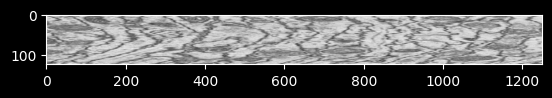

In [10]:
plt.imshow(raw_volume[:, :, raw_volume.shape[2] // 2], cmap="gray")
